### Lighter Detection Using Azure Custom Vision
#### Object Detection

##### Importing Azure Custome Vision, Python modules, and helper functions

In [1]:
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

import os, time, uuid
from azure.cognitiveservices.vision.customvision.training import CustomVisionTrainingClient
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateBatch, ImageFileCreateEntry, Region
from msrest.authentication import ApiKeyCredentials

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

##### Training and Prediction Endpoints, Keys, and Resource IDs separately

In [3]:
TRAINING_ENDPOINT = os.getenv('TRAINING_ENDPOINT')
training_key = os.getenv('training_key')
training_resource_id = os.getenv('training_resource_id')

PREDICTION_ENDPOINT = os.getenv('PREDICTION_ENDPOINT')
prediction_key = os.getenv('prediction_key')
prediction_resource_id = os.getenv('prediction_resource_id')

##### Instantiate and authenticate the training client with endpoint and key

In [5]:
training_credentials = ApiKeyCredentials(in_headers={"Training-key": training_key})
trainer = CustomVisionTrainingClient(TRAINING_ENDPOINT, training_credentials)

In [6]:
trainer.api_version


'3.4-preview'

##### Creating Training Project First

In [7]:
# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection" and domain.name == "General")

# Create a new project
print ("Your Object Detection Training project has been created. Please move on.")
project_name = uuid.uuid4()
project = trainer.create_project(project_name, domain_id=obj_detection_domain.id)

Your Object Detection Training project has been created. Please move on.


In [8]:
project.as_dict()

{'id': 'd6295049-73ee-4da1-b222-37df1f7a41a7',
 'name': '386a276d-4dc9-4312-8e6a-677ad71864ec',
 'description': '',
 'settings': {'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1',
  'classification_type': 'Multilabel',
  'target_export_platforms': [],
  'use_negative_set': True,
  'image_processing_settings': {'augmentation_methods': {'rotation': True,
    'scaling': True,
    'translation': True,
    'horizontal flip': True,
    'equalize': True,
    'solarize': True,
    'padtosquare': True}}},
 'created': '2023-09-10T06:05:04.723Z',
 'last_modified': '2023-09-10T06:05:04.723Z',
 'dr_mode_enabled': False,
 'status': 'Succeeded'}

In [9]:
project.status

'Succeeded'

##### Adding Tags based on training requirements
- We have 1 tag in the training process
    - Lighter

In [10]:
lighter_tag = trainer.create_tag(project.id, "lighter")

In [11]:
iteration = trainer.train_project(project.id)
while (iteration.status != "Completed"):
    iteration = trainer.get_iteration(project.id, iteration.id)
    print ("Training status: " + iteration.status)
    print ("Waiting 10 seconds...")
    time.sleep(10)

Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 seconds...
Training status: Training
Waiting 10 sec

In [12]:
iteration.as_dict()

{'id': '7ff29bc0-e947-4b38-bd4d-e6fc612260b8',
 'name': 'Iteration 1',
 'status': 'Completed',
 'created': '2023-09-10T06:05:04.726Z',
 'last_modified': '2023-09-10T06:31:26.973Z',
 'trained_at': '2023-09-10T06:31:26.968Z',
 'project_id': 'd6295049-73ee-4da1-b222-37df1f7a41a7',
 'exportable': False,
 'domain_id': 'da2e3a8a-40a5-4171-82f4-58522f70fbc1',
 'training_type': 'Regular',
 'reserved_budget_in_hours': 0,
 'training_time_in_minutes': 3}

In [13]:
model_perf = trainer.get_iteration_performance(project.id, '7ff29bc0-e947-4b38-bd4d-e6fc612260b8')

In [14]:
model_perf.as_dict()

{'per_tag_performance': [{'id': 'a9eda66a-caea-449b-a7e0-8c7b1fe0c467',
   'name': 'lighter',
   'precision': 1.0,
   'precision_std_deviation': 0.0,
   'recall': 0.125,
   'recall_std_deviation': 0.0,
   'average_precision': 0.88214284}],
 'precision': 1.0,
 'precision_std_deviation': 0.0,
 'recall': 0.125,
 'recall_std_deviation': 0.0,
 'average_precision': 0.88214284}

##### Publishing the Model to the Project Endpoint

In [15]:
## Setting the Iteration Name, this will be used when Model training is completed
publish_iteration_name = "GHz-azure-object-detection-customviz-lighter"
# The iteration is now trained. Publish it to the project endpoint
trainer.publish_iteration(project.id, iteration.id, publish_iteration_name, prediction_resource_id)
print ("Done!")

Done!


##### Performing Prediction

In [16]:
prediction_credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
predictor = CustomVisionPredictionClient(PREDICTION_ENDPOINT, prediction_credentials)

In [17]:
predictor.api_version

'3.1'

In [18]:
test_images_path = '../material_preparation_step/lighter_test_images/'

In [19]:
# list to store files
res = []

# Iterate directory
for file_path in os.listdir(test_images_path):
    # check if current file_path is a file
    if os.path.isfile(os.path.join(test_images_path, file_path)):
        # add filename to list
        res.append(file_path)
print(res)

['lighter_test_set_3of5.jpg', 'lighter_test_set_4of5.jpg', 'lighter_test_set_2of5.jpg', 'lighter_test_set_5of5.jpg', 'lighter_test_set_1of5.jpg']


In [24]:
def perform_prediction(folder_image_path, image_file_name):
    with open(os.path.join (folder_image_path,  image_file_name), "rb") as image_contents:
        print("Image: "+ image_file_name)
        results = predictor.detect_image(project.id, publish_iteration_name, image_contents.read())
        img_view_ready = Image.open(image_contents)
        plt.figure()
        plt.imshow(img_view_ready)
        for prediction in results.predictions:
            print("\t" + prediction.tag_name +
                  ": {0:.2f}%".format(prediction.probability * 100))

Image: lighter_test_set_3of5.jpg
	lighter: 37.84%
	lighter: 21.17%
	lighter: 2.76%
	lighter: 2.51%
	lighter: 2.30%
	lighter: 1.95%
	lighter: 1.70%
	lighter: 1.23%
	lighter: 1.20%
	lighter: 1.08%
	lighter: 1.05%
	lighter: 0.99%
	lighter: 0.96%
	lighter: 0.89%
	lighter: 0.86%
	lighter: 0.85%
	lighter: 0.84%
	lighter: 0.84%
	lighter: 0.80%
	lighter: 0.77%
	lighter: 0.76%
	lighter: 0.74%
	lighter: 0.73%
	lighter: 0.73%
	lighter: 0.69%
	lighter: 0.69%
	lighter: 0.67%
	lighter: 0.67%
	lighter: 0.67%
	lighter: 0.62%
	lighter: 0.60%
	lighter: 0.59%
	lighter: 0.58%
	lighter: 0.58%
	lighter: 0.56%
	lighter: 0.56%
	lighter: 0.56%
	lighter: 0.54%
	lighter: 0.54%
	lighter: 0.53%
	lighter: 0.53%
	lighter: 0.52%
	lighter: 0.52%
	lighter: 0.51%
	lighter: 0.50%
Image: lighter_test_set_4of5.jpg
	lighter: 78.52%
	lighter: 4.11%
	lighter: 2.67%
	lighter: 0.69%
	lighter: 0.68%
	lighter: 0.64%
	lighter: 0.62%
	lighter: 0.55%
Image: lighter_test_set_2of5.jpg
	lighter: 41.13%
	lighter: 20.07%
	lighter: 15.26%

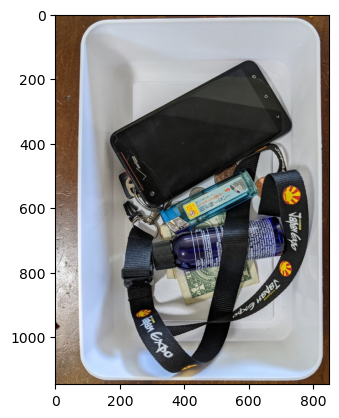

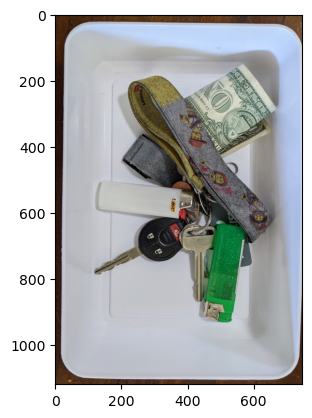

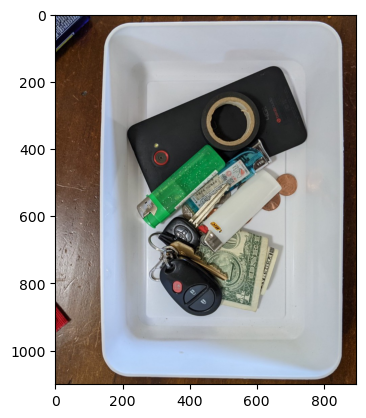

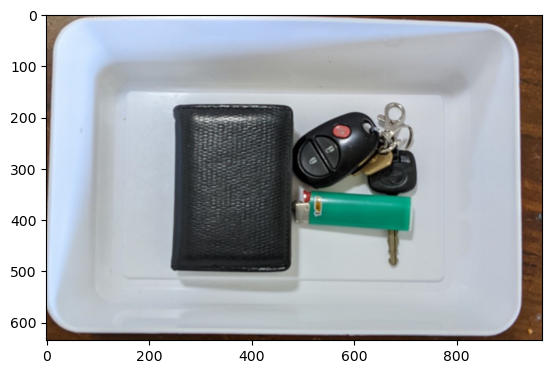

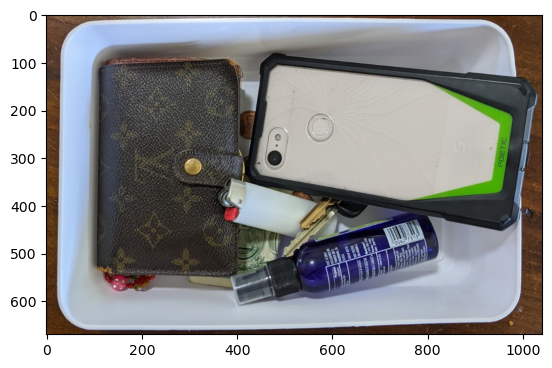

In [26]:
for img_file_name in res:
    perform_prediction(test_images_path, img_file_name)
    print('==========================')